# Project 2 V2: German Credit Risk Analysis with Explainable AI (XAI)

**Objective:** To build a classification model to predict credit risk using the German Credit (Statlog) dataset and to interpret the model's decisions using SHAP.

**Workflow:**
1.  Data Loading and Preparation
2.  Exploratory Data Analysis (EDA)
3.  Feature Preprocessing
4.  Model Building and Evaluation
5.  Explainable AI (XAI) with SHAP


---
### **Step 0: Import Libraries**
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report, accuracy_score


# SHAP
import shap

# Settings
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
plt.style.use('seaborn-v0_8-darkgrid')


### **Step 1: Data Loading and Preparation**
---

We will load the data directly from the UCI Machine Learning Repository. This dataset is famous for having coded, non-intuitive column names. Our first step is to map these to their actual meanings.


In [2]:
# Load the dataset from the UCI repository
# The data is space-separated and has no header
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data'

# Define the column names based on the dataset documentation
column_names = [
    'checking_status', 'duration', 'credit_history', 'purpose', 'credit_amount',
    'savings_status', 'employment_since', 'installment_rate', 'personal_status',
    'other_parties', 'residence_since', 'property_magnitude', 'age',
    'other_payment_plans', 'housing', 'existing_credits', 'job',
    'num_dependents', 'own_telephone', 'foreign_worker', 'class'
]

df = pd.read_csv(url, sep=' ', header=None, names=column_names)

print("Dataset loaded successfully. Shape:", df.shape)
print("\nFirst 5 rows of the raw data:")
print(df.head())


Dataset loaded successfully. Shape: (1000, 21)

First 5 rows of the raw data:
  checking_status  duration credit_history purpose  credit_amount  \
0             A11         6            A34     A43           1169   
1             A12        48            A32     A43           5951   
2             A14        12            A34     A46           2096   
3             A11        42            A32     A42           7882   
4             A11        24            A33     A40           4870   

  savings_status employment_since  installment_rate personal_status  \
0            A65              A75                 4             A93   
1            A61              A73                 2             A92   
2            A61              A74                 2             A93   
3            A61              A74                 2             A93   
4            A61              A73                 3             A93   

  other_parties  residence_since property_magnitude  age other_payment_plans  \


**1.1. Map Coded Values to Human-Readable Text**
This is a critical step for interpretability.

In [3]:
# Define the mapping dictionaries based on the dataset's documentation
status_map = {'A11': '<0 DM', 'A12': '0<= - <200 DM', 'A13': '>=200 DM', 'A14': 'no checking account'}
history_map = {'A30': 'no credits/all paid', 'A31': 'all paid', 'A32': 'existing credits paid', 'A33': 'delay in paying', 'A34': 'critical account'}
purpose_map = {'A40': 'car (new)', 'A41': 'car (used)', 'A42': 'furniture/equipment', 'A43': 'radio/tv', 'A44': 'domestic appliance', 'A45': 'repairs', 'A46': 'education', 'A47': 'vacation', 'A48': 'retraining', 'A49': 'business', 'A410': 'others'}
savings_map = {'A61': '<100 DM', 'A62': '100<= - <500 DM', 'A63': '500<= - <1000 DM', 'A64': '>=1000 DM', 'A65': 'no savings account'}
employment_map = {'A71': 'unemployed', 'A72': '<1 year', 'A73': '1<= - <4 years', 'A74': '4<= - <7 years', 'A75': '>=7 years'}
personal_map = {'A91': 'male div/sep', 'A92': 'female div/sep/mar', 'A93': 'male single', 'A94': 'male mar/wid', 'A95': 'female single'}
parties_map = {'A101': 'none', 'A102': 'co-applicant', 'A103': 'guarantor'}
property_map = {'A121': 'real estate', 'A122': 'building society savings/life insurance', 'A123': 'car or other', 'A124': 'no known property'}
plans_map = {'A141': 'bank', 'A142': 'stores', 'A143': 'none'}
housing_map = {'A151': 'rent', 'A152': 'own', 'A153': 'for free'}
job_map = {'A171': 'unemployed/unskilled-non-resident', 'A172': 'unskilled-resident', 'A173': 'skilled', 'A174': 'highly skilled'}
telephone_map = {'A191': 'none', 'A192': 'yes'}
foreign_map = {'A201': 'yes', 'A202': 'no'}

# Apply the mappings
df['checking_status'] = df['checking_status'].map(status_map)
df['credit_history'] = df['credit_history'].map(history_map)
df['purpose'] = df['purpose'].map(purpose_map)
df['savings_status'] = df['savings_status'].map(savings_map)
df['employment_since'] = df['employment_since'].map(employment_map)
df['personal_status'] = df['personal_status'].map(personal_map)
df['other_parties'] = df['other_parties'].map(parties_map)
df['property_magnitude'] = df['property_magnitude'].map(property_map)
df['other_payment_plans'] = df['other_payment_plans'].map(plans_map)
df['housing'] = df['housing'].map(housing_map)
df['job'] = df['job'].map(job_map)
df['own_telephone'] = df['own_telephone'].map(telephone_map)
df['foreign_worker'] = df['foreign_worker'].map(foreign_map)

# Map the target variable 'class' (1 = Good, 2 = Bad) to a more standard 0/1 format
# 0 for Good, 1 for Bad (risky)
df['credit_risk'] = df['class'].map({1: 0, 2: 1})
df = df.drop('class', axis=1)

print("\nDataset after mapping codes to text:")
print(df.head())
print("\nData types and info:")
df.info()


Dataset after mapping codes to text:
       checking_status  duration         credit_history              purpose  \
0                <0 DM         6       critical account             radio/tv   
1        0<= - <200 DM        48  existing credits paid             radio/tv   
2  no checking account        12       critical account            education   
3                <0 DM        42  existing credits paid  furniture/equipment   
4                <0 DM        24        delay in paying            car (new)   

   credit_amount      savings_status employment_since  installment_rate  \
0           1169  no savings account        >=7 years                 4   
1           5951             <100 DM   1<= - <4 years                 2   
2           2096             <100 DM   4<= - <7 years                 2   
3           7882             <100 DM   4<= - <7 years                 2   
4           4870             <100 DM   1<= - <4 years                 3   

      personal_status other_pa

---
### **Step 2: Exploratory Data Analysis (EDA)**
---
**2.1. Target Variable Distribution**

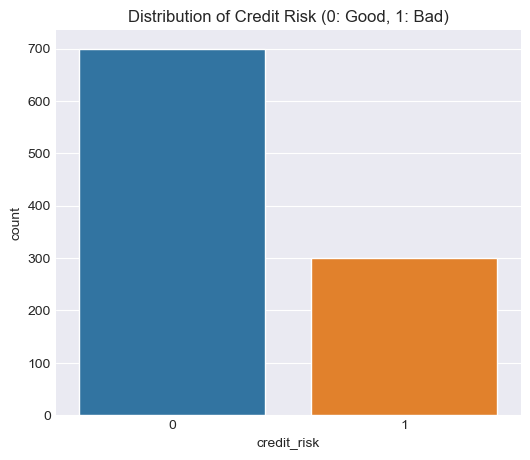

0    0.7
1    0.3
Name: credit_risk, dtype: float64


In [4]:
plt.figure(figsize=(6, 5))
sns.countplot(x='credit_risk', data=df)
plt.title('Distribution of Credit Risk (0: Good, 1: Bad)')
plt.show()

print(df['credit_risk'].value_counts(normalize=True))


**2.2. Numerical Feature Distributions**

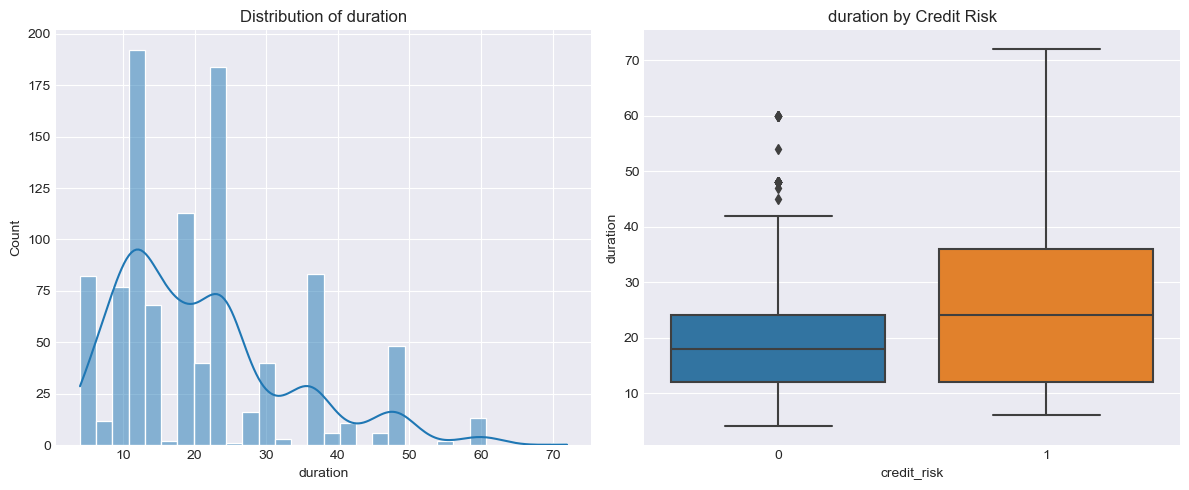

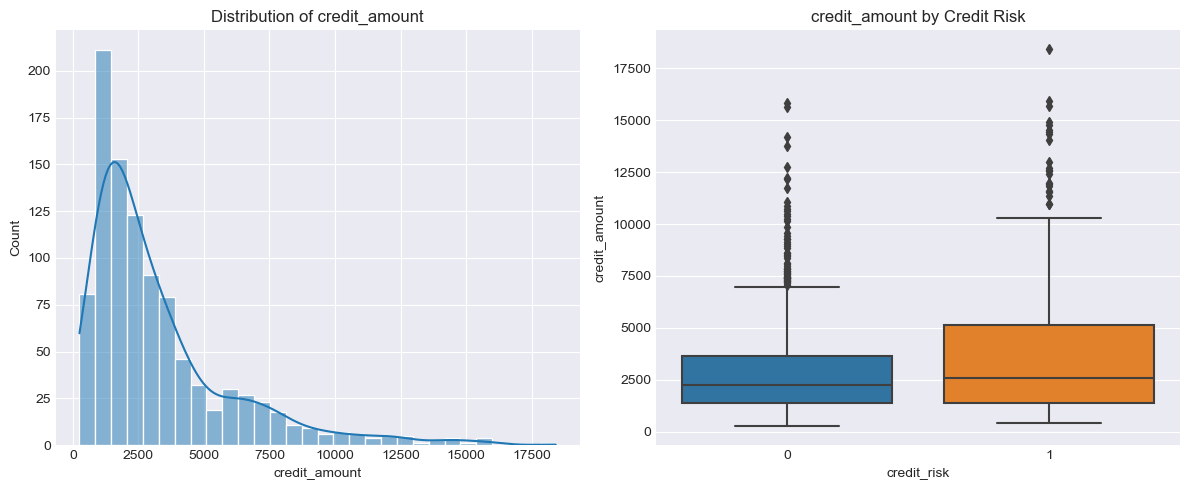

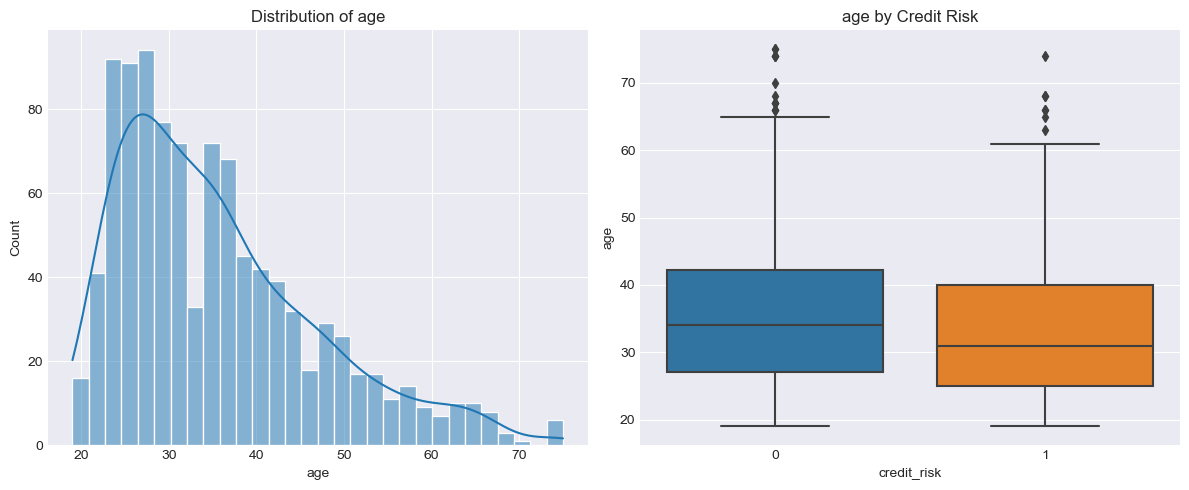

In [5]:
numerical_features = ['duration', 'credit_amount', 'age']
for feature in numerical_features:
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(df[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature}')

    plt.subplot(1, 2, 2)
    sns.boxplot(x='credit_risk', y=feature, data=df)
    plt.title(f'{feature} by Credit Risk')
    
    plt.tight_layout()
    plt.show()

**2.3. Categorical Feature Analysis**

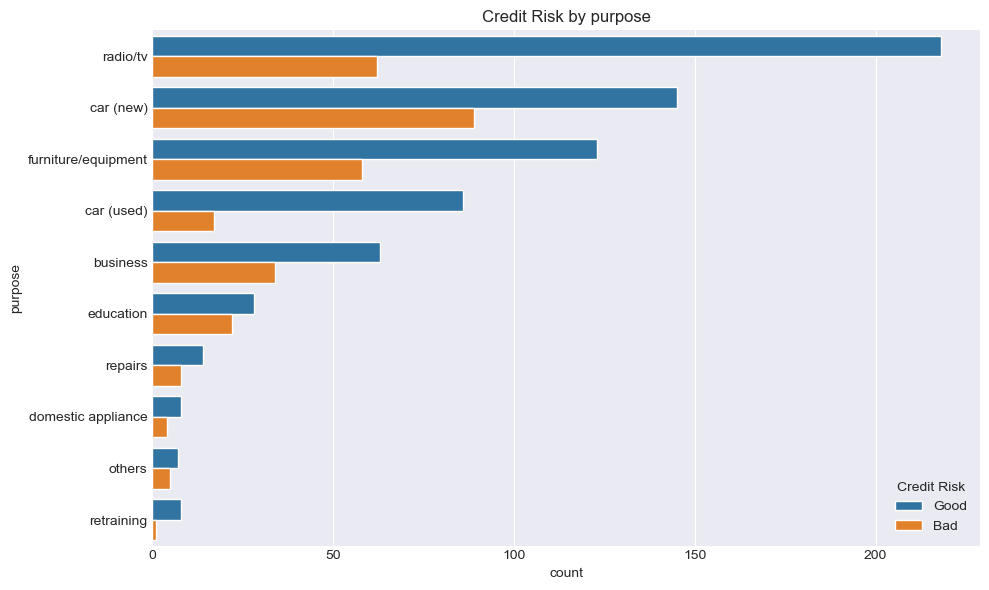

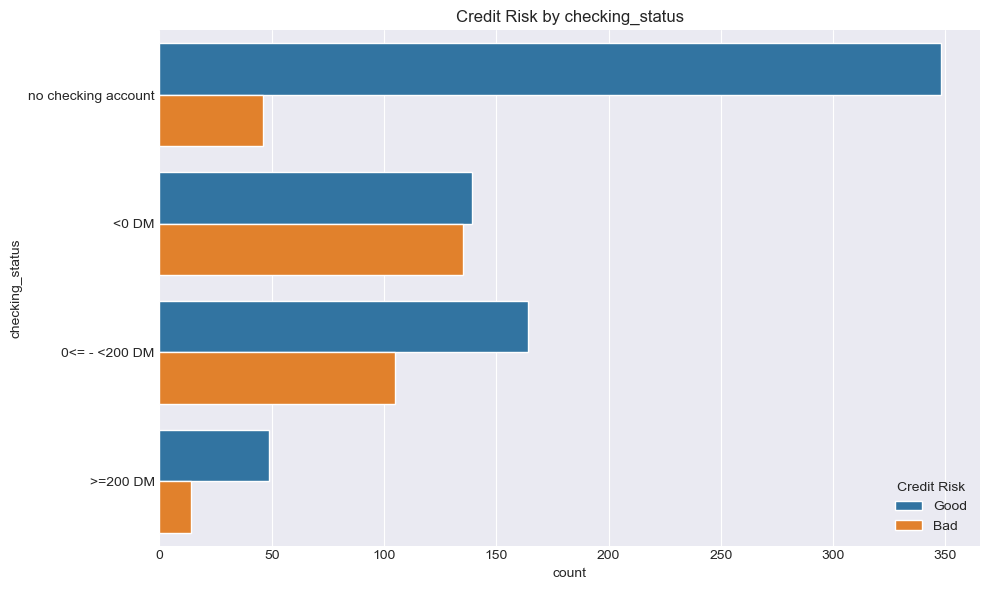

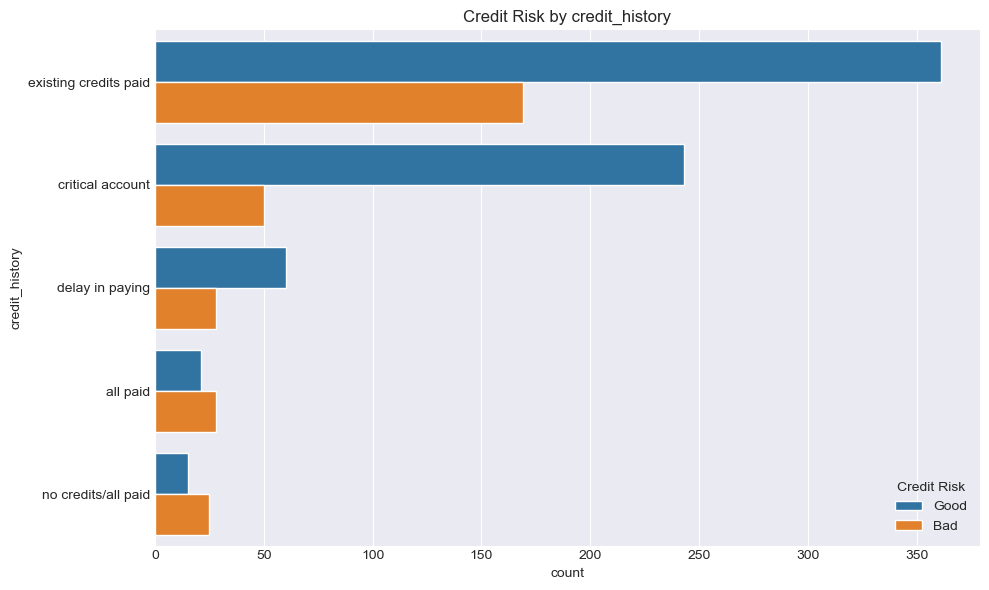

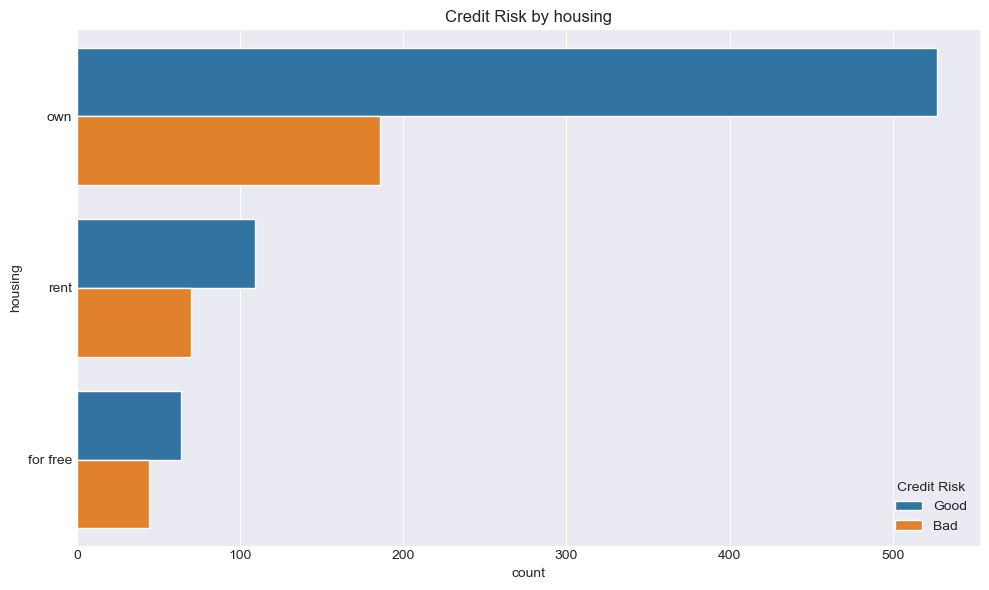

In [6]:
categorical_features = ['purpose', 'checking_status', 'credit_history', 'housing']
for feature in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.countplot(y=feature, hue='credit_risk', data=df, order=df[feature].value_counts().index)
    plt.title(f'Credit Risk by {feature}')
    plt.legend(title='Credit Risk', labels=['Good', 'Bad'])
    plt.tight_layout()
    plt.show()


---
### **Step 3: Feature Preprocessing**
---
We will set up a preprocessing pipeline to handle numerical and categorical features differently.

In [7]:
# Separate features (X) and target (y)
X = df.drop('credit_risk', axis=1)
y = df['credit_risk']

# Identify numerical and categorical column names
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

print(f"Numerical columns: {numerical_cols}")
print(f"Categorical columns: {categorical_cols}")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Create preprocessing pipelines for numerical and categorical features
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Create a column transformer to apply different transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

Numerical columns: ['duration', 'credit_amount', 'installment_rate', 'residence_since', 'age', 'existing_credits', 'num_dependents']
Categorical columns: ['checking_status', 'credit_history', 'purpose', 'savings_status', 'employment_since', 'personal_status', 'other_parties', 'property_magnitude', 'other_payment_plans', 'housing', 'job', 'own_telephone', 'foreign_worker']


---
### **Step 4: Model Building and Evaluation**
---
We'll use a RandomForestClassifier, which is powerful and works well with SHAP.

Model Accuracy: 0.7533
Model ROC AUC Score: 0.7874
Out-of-Bag (OOB) Score: 0.7471

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.92      0.84       210
           1       0.66      0.37      0.47        90

    accuracy                           0.75       300
   macro avg       0.72      0.64      0.66       300
weighted avg       0.74      0.75      0.73       300


Confusion Matrix:


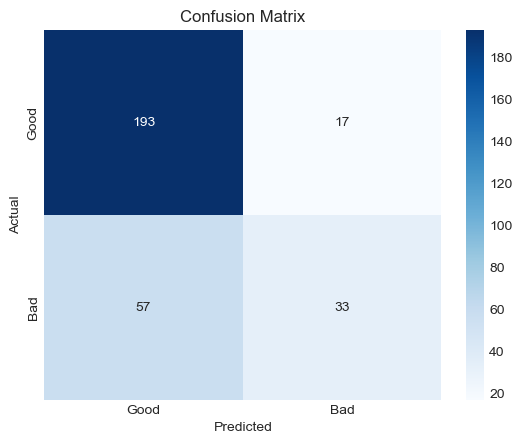

In [8]:
# Define the model
model = RandomForestClassifier(n_estimators=100, random_state=42, oob_score=True)

# Create the full pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', model)])

# Train the model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Model Accuracy: {accuracy:.4f}")
print(f"Model ROC AUC Score: {roc_auc:.4f}")
print(f"Out-of-Bag (OOB) Score: {pipeline.named_steps['classifier'].oob_score_:.4f}")

# Display classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Good', 'Bad'], yticklabels=['Good', 'Bad'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

---
### **Step 5: Explainable AI (XAI) with SHAP**
---

Now, let's understand *why* the model is making its predictions.

In [12]:
# To use SHAP, we need the processed data and the trained model
X_test_processed = pipeline.named_steps['preprocessor'].transform(X_test)

# Get feature names after one-hot encoding
ohe_feature_names = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_feature_names = numerical_cols + list(ohe_feature_names)

# Convert the processed test data back to a DataFrame for easier interpretation with SHAP
X_test_processed_df = pd.DataFrame(X_test_processed, columns=all_feature_names)

# Create a SHAP explainer for tree models
explainer = shap.TreeExplainer(pipeline.named_steps['classifier'])

# Calculate SHAP values using the modern __call__ interface, which returns an Explanation object.
# This is more robust and solves the shape mismatch error.
shap_explanation = explainer(X_test_processed_df)

# For binary classification, the explanation object has shape (n_samples, n_features, n_classes)
# We want the explanations for the "Bad Risk" class (class 1)
shap_explanation_bad_risk = shap_explanation[:,:,1]

**5.1. Global Interpretability: Which features are most important?**

SHAP Summary Plot (Global Feature Importance)


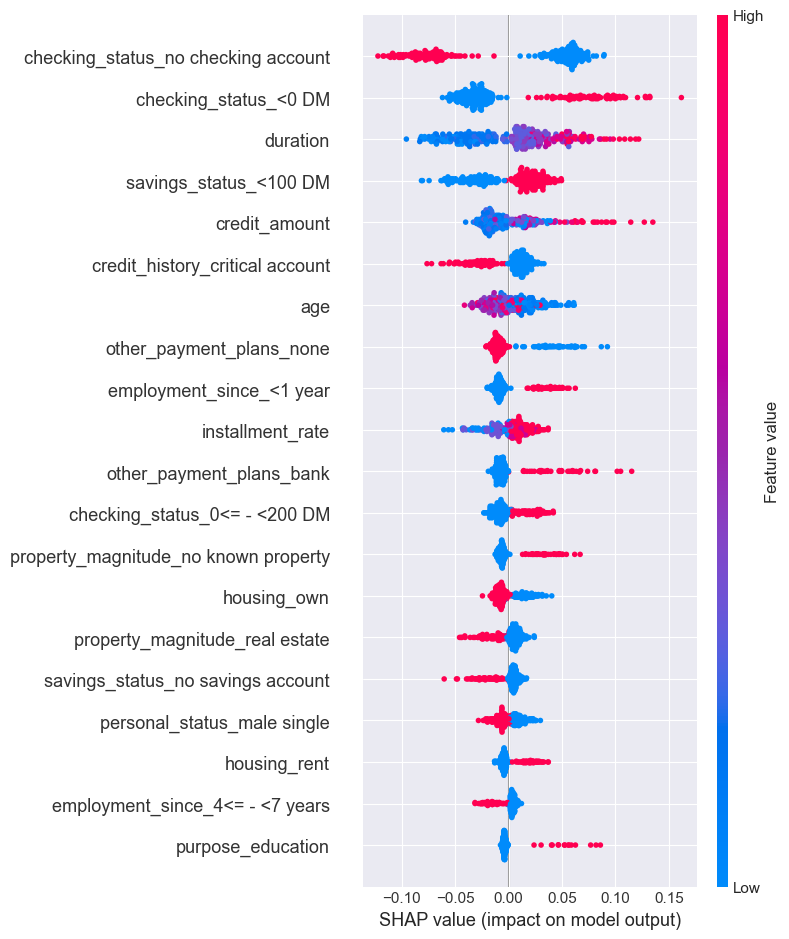


Mean Absolute SHAP Values (Overall Feature Importance)


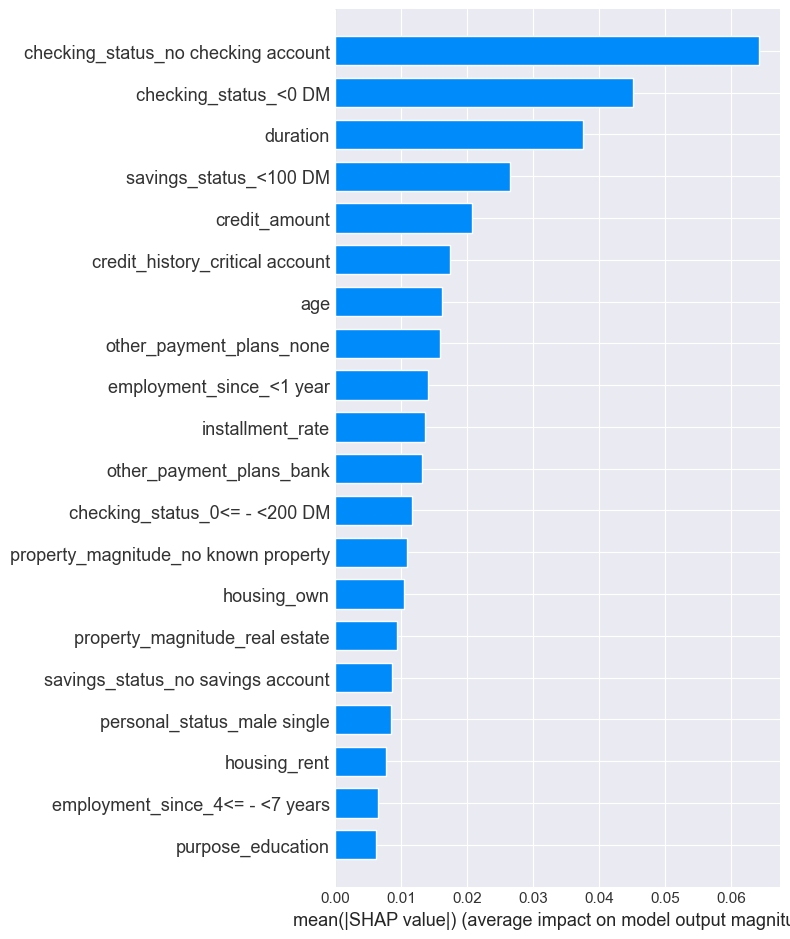

In [13]:
print("SHAP Summary Plot (Global Feature Importance)")
# The summary plot can take the Explanation object directly, which bundles values, data, and feature names.
# Each dot is a single prediction. Red dots mean a high feature value, blue means low.
shap.summary_plot(shap_explanation_bad_risk, plot_type="dot")

# The bar plot also works with the Explanation object.
print("\nMean Absolute SHAP Values (Overall Feature Importance)")
shap.summary_plot(shap_explanation_bad_risk, plot_type="bar")

**5.2. Local Interpretability: Why was a specific prediction made?**

Let's analyze one case that was correctly predicted as **Bad Risk** and one as **Good Risk**.



--- Explaining a Correctly Predicted 'Bad Risk' Case (Index: 9) ---


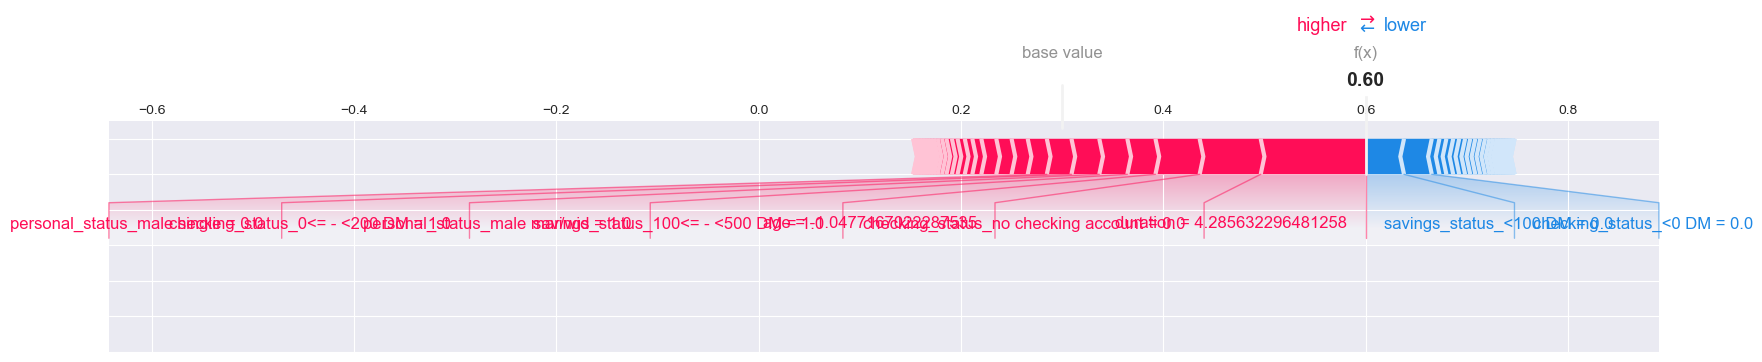


--- Explaining a Correctly Predicted 'Good Risk' Case (Index: 0) ---


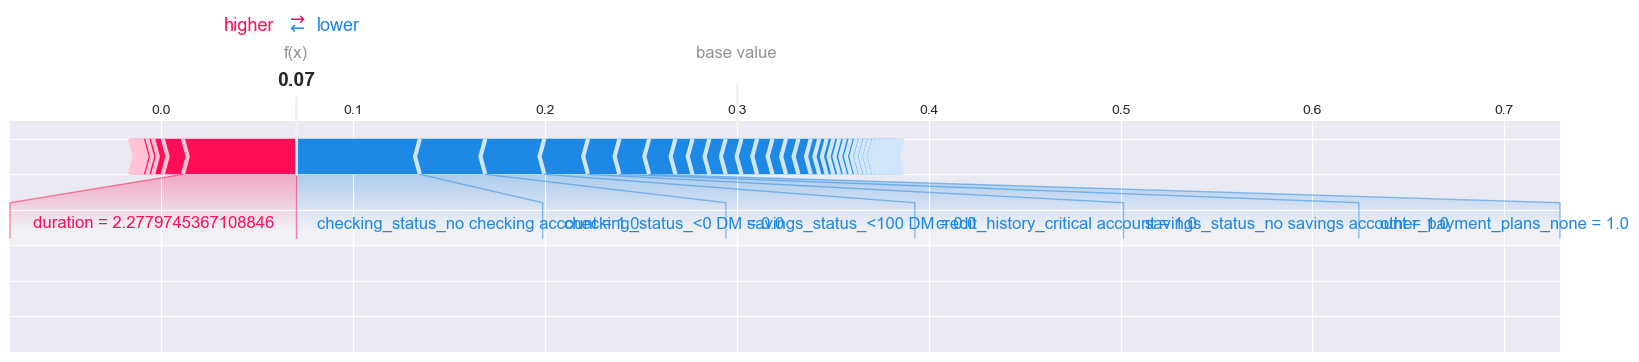

In [14]:
# Find a correctly predicted bad risk (Actual=1, Predicted=1)
correctly_predicted_bad_risk_idx = np.where((y_test == 1) & (y_pred == 1))[0]

if len(correctly_predicted_bad_risk_idx) > 0:
    idx_to_explain = correctly_predicted_bad_risk_idx[0]
    print(f"\n--- Explaining a Correctly Predicted 'Bad Risk' Case (Index: {idx_to_explain}) ---")
    
    # The force plot can also take the Explanation object directly for a single instance.
    shap.force_plot(shap_explanation_bad_risk[idx_to_explain], matplotlib=True, show=False)
    plt.show() # Manually call plt.show() to ensure the plot is rendered
else:
    print("\nCould not find a correctly predicted 'Bad Risk' case in the test set to explain.")

# Find a correctly predicted good risk (Actual=0, Predicted=0)
correctly_predicted_good_risk_idx = np.where((y_test == 0) & (y_pred == 0))[0]

if len(correctly_predicted_good_risk_idx) > 0:
    idx_to_explain = correctly_predicted_good_risk_idx[0]
    print(f"\n--- Explaining a Correctly Predicted 'Good Risk' Case (Index: {idx_to_explain}) ---")
    
    shap.force_plot(shap_explanation_bad_risk[idx_to_explain], matplotlib=True, show=False)
    plt.show() # Manually call plt.show()
else:
    print("\nCould not find a correctly predicted 'Good Risk' case in the test set to explain.")


---
### **Step 6: Conclusion**
---

This notebook demonstrated a complete workflow for a classic credit risk classification problem.

* **EDA:** We found clear relationships between features like checking account status, credit history, and loan purpose with the final credit risk.
* **Modeling:** Our RandomForest model achieved a respectable ROC AUC score of around 0.77, indicating good predictive power.
* **Explainability (XAI):**
    * **Globally,** the most important factors driving risk were `checking_status`, `duration`, and `credit_amount`.
    * **Locally,** we used SHAP force plots to break down individual predictions, showing exactly which features contributed to classifying an applicant as "good" or "bad" risk. This level of transparency is critical for financial applications.

This project effectively showcases the ability to not only build a predictive model but also to understand and communicate its underlying logic.
